In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.svm import SVC, SVR
from sklearn.metrics import classification_report, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import nltk
from gensim.models.keyedvectors import KeyedVectors
nltk.download('stopwords')
from nltk.corpus import stopwords
import gc 

[nltk_data] Downloading package stopwords to /Users/misha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset_dir = '/Users/misha/Datasets/DAIC_WOZ'
label_dir = '/Users/misha/Datasets/DAIC_WOZ/labels/'
data_dir = '/Users/misha/Datasets/DAIC_WOZ/data/'
splitted_dataset_dir = '/Users/misha/Datasets/DAIC_WOZ/splitted_dataset/'

In [3]:
if not os.path.exists(splitted_dataset_dir+'train_data'):
    os.makedirs(splitted_dataset_dir+'train_data')

if not os.path.exists(splitted_dataset_dir+'dev_data'):
    os.makedirs(splitted_dataset_dir+'dev_data')
    
if not os.path.exists(splitted_dataset_dir+'test_data'):
    os.makedirs(splitted_dataset_dir+'test_data')

In [4]:
# dev = np.array(pd.read_csv(label_dir+'train_split.csv',delimiter=',',encoding='utf-8'))[:, 0:2]
# train = np.array(pd.read_csv(label_dir+'test_split.csv',delimiter=',',encoding='utf-8'))[:, 0:2]
# test = np.array(pd.read_csv(label_dir+'dev_split.csv',delimiter=',',encoding='utf-8'))[:, 0:2]

train = np.array(pd.read_csv(label_dir+'train_split.csv',delimiter=',',encoding='utf-8'))
dev = np.array(pd.read_csv(label_dir+'dev_split.csv',delimiter=',',encoding='utf-8'))
test = np.array(pd.read_csv(label_dir+'test_split.csv',delimiter=',',encoding='utf-8'))

In [5]:
print('train_size: ', len(train))
print('dev_size: ', len(dev))
print('test_size: ', len(test))

train_size:  163
dev_size:  56
test_size:  56


In [6]:
# for i in range(len(train)):
#     source_dir = data_dir + str(int(train[i][0])) + "_P"
#     target_dir = splitted_dataset_dir + 'train_data/' + str(int(train[i][0])) + "_P"
#     shutil.move(source_dir, target_dir)

In [7]:
# for i in range(len(dev)):
#     source_dir = data_dir + str(int(dev[i][0])) + "_P"
#     target_dir = splitted_dataset_dir + 'dev_data/' + str(int(dev[i][0])) + "_P"
#     shutil.move(source_dir, target_dir)

In [8]:
# for i in range(len(test)):
#     source_dir = data_dir + str(int(test[i][0])) + "_P"
#     target_dir = splitted_dataset_dir + 'test_data/' + str(int(test[i][0])) + "_P"
#     shutil.move(source_dir, target_dir)

In [9]:
dataset1 = dev
dataset2 = test
dataset3 = train
dataset = np.concatenate((dataset1, np.concatenate((dataset2, dataset3))))

In [10]:
dataset

array([[300, 'male', 0, 2, 0, 25],
       [301, 'male', 0, 3, 0, 17],
       [306, 'female', 0, 0, 0, 21],
       ...,
       [702, 'male', 0, 0, 0, 19],
       [703, 'male', 0, 8, 0, 28],
       [707, 'male', 0, 1, 0, 23]], dtype=object)

In [11]:
positive = []
negative = []

In [12]:
for i in range(len(dataset)):
    if dataset[i][0]<=310 and dataset[i][0]>=300:
        if(dataset[i][1] == 0):
            positive.append(int(dataset[i][0]))
        else:
            negative.append(int(dataset[i][0]))

    elif dataset[i][0]<=355 and dataset[i][0]>=345:
        if(dataset[i][1] == 0):
            positive.append(int(dataset[i][0]))
        else:
            negative.append(int(dataset[i][0]))

In [13]:
for i in range(len(dataset)):
        if(dataset[i][2] == 0):
            positive.append(int(dataset[i][0]))
        else:
            negative.append(int(dataset[i][0]))


In [14]:
len(negative)

88

In [15]:
len(positive)

209

In [16]:
# preparing text data from the transcripts   

def get_data_text(train_val_test_dir):
    df_text = pd.DataFrame(columns=['ID', 'text'])
    i = 0
    for name in os.listdir(splitted_dataset_dir + train_val_test_dir):
        data_text = []
        if name.startswith('.'):
            continue
            
        text_file_name = splitted_dataset_dir + train_val_test_dir + '/' + \
                             str(name) + '/' + str(name[:3]) + "_Transcript.csv"
        
        df_temp = pd.read_csv(text_file_name, delimiter=',', encoding='utf-8')
        indices_to_remove = df_temp[df_temp['Confidence'] < 0.5].index
        df_temp = df_temp.drop(index=indices_to_remove)
        df_temp = df_temp.drop(['Start_Time', 'End_Time', 'Confidence'], axis=1)
        df_text.loc[i] = [name[:3], np.array(df_temp)]
        i += 1
    df_text['ID'] = df_text['ID'].astype(str)
    return df_text

In [17]:
df_text_train = get_data_text('train_data')
df_text_dev = get_data_text('dev_data')
df_text_test = get_data_text('test_data')

In [18]:
df_text_train = df_text_train.sort_values(by=['ID'])
df_text_dev = df_text_dev.sort_values(by=['ID'])
df_text_test = df_text_test.sort_values(by=['ID'])

In [19]:
df_train_split = pd.read_csv(label_dir+'train_split.csv', delimiter=',', encoding='utf-8')
df_dev_split = pd.read_csv(label_dir+'dev_split.csv', delimiter=',', encoding='utf-8')
df_test_split = pd.read_csv(label_dir+'test_split.csv', delimiter=',', encoding='utf-8')
df_labels = pd.concat([df_train_split, df_dev_split, df_test_split])
df_labels = df_labels.reset_index(drop=True)
df_labels = df_labels.rename(columns={'Participant_ID': 'ID'})
df_labels['ID'] = df_labels['ID'].astype(str)
df_labels

,ID,Gender,PHQ_Binary,PHQ_Score,PCL-C (PTSD),PTSD Severity
0,302,male,0,4,0,28.0
1,303,female,0,0,0,17.0
2,304,female,0,6,0,20.0
3,305,male,0,7,0,28.0
4,307,female,0,4,0,23.0
...,...,...,...,...,...,...
270,712,male,0,0,0,21.0
271,715,male,0,7,0,55.0
272,716,male,1,15,1,73.0
273,717,male,0,1,0,20.0


In [20]:
df_text_train = pd.merge(df_text_train, df_labels, on='ID')
df_text_dev = pd.merge(df_text_dev, df_labels, on='ID')
df_text_test = pd.merge(df_text_test, df_labels, on='ID')

df_text_train = df_text_train.reset_index(drop=True)
df_text_dev = df_text_dev.reset_index(drop=True)
df_text_test = df_text_test.reset_index(drop=True)

In [21]:
df_text_X = pd.concat([df_text_train, df_text_dev, df_text_test])
df_text_X = df_text_X.reset_index(drop=True)
df_text_X

,ID,text,Gender,PHQ_Binary,PHQ_Score,PCL-C (PTSD),PTSD Severity
0,302,"[[just move around a little bit], [ when you'r...",male,0,4,0,28.0
1,303,"[[wow okay], [ when you're finished when she's...",female,0,0,0,17.0
2,304,[[so we'll just move around a little bit tonig...,female,0,6,0,20.0
3,305,[[okay looks good so we can just move around a...,male,0,7,0,28.0
4,307,[[looking at you all right okay so now let's m...,female,0,4,0,23.0
...,...,...,...,...,...,...,...
270,712,"[[so friggin], [I'm pleased], [ are you okay w...",male,0,0,0,21.0
271,715,"[[okay], [ okay okay], [ and once you spend ju...",male,0,7,0,55.0
272,716,[[not very typical to that happen but just in ...,male,1,15,1,73.0
273,717,[[okay if you notice that she pauses for more ...,male,0,1,0,20.0


In [22]:
df_text_X

,ID,text,Gender,PHQ_Binary,PHQ_Score,PCL-C (PTSD),PTSD Severity
0,302,"[[just move around a little bit], [ when you'r...",male,0,4,0,28.0
1,303,"[[wow okay], [ when you're finished when she's...",female,0,0,0,17.0
2,304,[[so we'll just move around a little bit tonig...,female,0,6,0,20.0
3,305,[[okay looks good so we can just move around a...,male,0,7,0,28.0
4,307,[[looking at you all right okay so now let's m...,female,0,4,0,23.0
...,...,...,...,...,...,...,...
270,712,"[[so friggin], [I'm pleased], [ are you okay w...",male,0,0,0,21.0
271,715,"[[okay], [ okay okay], [ and once you spend ju...",male,0,7,0,55.0
272,716,[[not very typical to that happen but just in ...,male,1,15,1,73.0
273,717,[[okay if you notice that she pauses for more ...,male,0,1,0,20.0


In [23]:
df_text_X.to_csv('transcripts_daic.csv')

In [24]:
pd.read_csv('transcripts_daic.csv', index_col = [0])

,ID,text,Gender,PHQ_Binary,PHQ_Score,PCL-C (PTSD),PTSD Severity
0,302,"[['just move around a little bit']\n ["" when y...",male,0,4,0,28.0
1,303,"[['wow okay']\n ["" when you're finished when s...",female,0,0,0,17.0
2,304,"[[""so we'll just move around a little bit toni...",female,0,6,0,20.0
3,305,"[[""okay looks good so we can just move around ...",male,0,7,0,28.0
4,307,"[[""looking at you all right okay so now let's ...",female,0,4,0,23.0
...,...,...,...,...,...,...,...
270,712,"[['so friggin']\n [""I'm pleased""]\n [' are you...",male,0,0,0,21.0
271,715,[['okay']\n [' okay okay']\n [' and once you s...,male,0,7,0,55.0
272,716,"[[""not very typical to that happen but just in...",male,1,15,1,73.0
273,717,"[[""okay if you notice that she pauses for more...",male,0,1,0,20.0


In [25]:
X_text = np.array(df_text_X['text'])
Y_text = np.array(df_text_X['PHQ_Binary'])

X_text_test = np.array(df_text_test['text'])
Y_text_test = np.array(df_text_test['PHQ_Binary'])

In [26]:
Y_text = np.array(df_text_X['PHQ_Binary'])
Y_text

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0])

In [27]:
model = KeyedVectors.load_word2vec_format('/Users/misha/Datasets/GoogleNews-vectors-negative300.bin', binary=True)

stop_words = set(stopwords.words('english'))


def remove_StopWOrds(sentence):
    filtered_sentence = [] 
    for w in sentence: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    
    return filtered_sentence

def checkAcc(Y_pred, Y_test):
    correct = 0
    for i in range(len(Y_pred)):
        if(Y_pred[i] == Y_test[i]):
            correct+=1
    
    return float(correct)/len(Y_pred)


In [28]:
X_text.shape[0]

275

In [29]:
# Create the final_matrix for train data

max_num_words = 15
max_num_sentence = 200

final_matrix = np.zeros((X_text.shape[0], max_num_sentence, max_num_words))

for k in range(X_text.shape[0]):
    for i in range(min(max_num_sentence, len(X_text[k]))):
        try:
            sentence = ''.join(str(elem) for elem in X_text[k][i])
            sentence = sentence.split(" ")
#             print('sentence1: ', sentence)
        except:
            continue
        sentence = remove_StopWOrds(sentence)
#         print('sentence2: ', sentence)
        for j in range(min(max_num_words, len(sentence))):
            try:
                final_matrix[k][i][j] = np.average(np.array(model[sentence[j]]))
#                 print(' final_matrix: ', final_matrix[k][i][j])
            except:
                continue
                
X = np.zeros((len(X_text), max_num_sentence*max_num_words))

for i in range(len(final_matrix)):
    X[i] = final_matrix[i].flatten().reshape(1, -1)


In [30]:
X.shape

(275, 3000)

In [31]:
# Create the final_matrix for test data

max_num_words = 15
max_num_sentence = 200

final_matrix = np.zeros((X_text_test.shape[0], max_num_sentence, max_num_words))

for k in range(X_text_test.shape[0]):
    for i in range(min(max_num_sentence, len(X_text_test[k]))):
        try:
            sentence = ''.join(str(elem) for elem in X_text_test[k][i])
            sentence = sentence.split(" ")
#             print('sentence1: ', sentence)
        except:
            continue
        sentence = remove_StopWOrds(sentence)
#         print('sentence2: ', sentence)
        for j in range(min(max_num_words, len(sentence))):
            try:
                final_matrix[k][i][j] = np.average(np.array(model[sentence[j]]))
#                 print(' final_matrix: ', final_matrix[k][i][j])
            except:
                continue
                
X_test = np.zeros((len(X_text_test), max_num_sentence*max_num_words))

for i in range(len(final_matrix)):
    X_test[i] = final_matrix[i].flatten().reshape(1, -1)

print(final_matrix.shape)
print(X_test.shape)

gc.collect()

(56, 200, 15)
(56, 3000)


0

In [32]:
# Random Forest Classifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X,Y_text)
Y_pred_rf = clf_rf.predict(X_test)
print("Random forests: ")
print(classification_report(Y_text_test,Y_pred_rf))
print("Train: "+ str(clf_rf.score(X,Y_text)))
print("Test: " + str(clf_rf.score(X_test,Y_text_test)))

Random forests: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        39
           1       1.00      1.00      1.00        17

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56

Train: 1.0
Test: 1.0


In [35]:
Y_pred_rf

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0])

In [36]:
Y_text_test

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0])

In [39]:
X_text = np.array(df_text_X['text'])
Y_text = np.array(df_text_X['PHQ_Score'])

X_text_test = np.array(df_text_test['text'])
Y_text_test = np.array(df_text_test['PHQ_Score'])

In [40]:
# Regression model based on PHQ_Score and text data

mae_list = []
rmse_list = []

svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
# Create a KFold instance with 10 splits
kf = KFold(n_splits=10)

X_train = X
Y_train = Y_text

# Loop through the splits (each split is a tuple of train and test indices)
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]
    
    print(f'Fold {i+1}:')
    print(f'X_train shape: {x_train.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'X_test shape: {x_test.shape}')
    print(f'y_test shape: {y_test.shape}')
        
    # Train your model on the train data and test it on the test data
    svr_model.fit(x_train, y_train)
    y_pred = svr_model.predict(x_test)
    mae = mean_absolute_error(y_test, y_pred)
    mae_list.append(mae)
    print('mae: ', mae)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    print('rmse: ', rmse)
    rmse_list.append(rmse)

mean_mae = sum(mae_list) / len(mae_list)
mean_rmse = sum(rmse_list) / len(rmse_list)
print('mean mae: ', mean_mae)
print('mean rmse: ', mean_rmse)

Fold 1:
X_train shape: (247, 3000)
y_train shape: (247,)
X_test shape: (28, 3000)
y_test shape: (28,)
mae:  4.496324025481653
rmse:  6.1827698417934265
Fold 2:
X_train shape: (247, 3000)
y_train shape: (247,)
X_test shape: (28, 3000)
y_test shape: (28,)
mae:  6.605225736710095
rmse:  7.985319024028381
Fold 3:
X_train shape: (247, 3000)
y_train shape: (247,)
X_test shape: (28, 3000)
y_test shape: (28,)
mae:  4.367378209268531
rmse:  5.254948875436454
Fold 4:
X_train shape: (247, 3000)
y_train shape: (247,)
X_test shape: (28, 3000)
y_test shape: (28,)
mae:  4.927655222851491
rmse:  5.725331412200282
Fold 5:
X_train shape: (247, 3000)
y_train shape: (247,)
X_test shape: (28, 3000)
y_test shape: (28,)
mae:  4.592805857816581
rmse:  5.377077883076906
Fold 6:
X_train shape: (248, 3000)
y_train shape: (248,)
X_test shape: (27, 3000)
y_test shape: (27,)
mae:  4.959098103290671
rmse:  6.005126974614039
Fold 7:
X_train shape: (248, 3000)
y_train shape: (248,)
X_test shape: (27, 3000)
y_test shap

In [34]:
# Visual data processing
def get_data_openface(train_val_test_dir):
    participants_IDs_path = {}
    df_openface = pd.DataFrame()
                               
    for name in os.listdir(splitted_dataset_dir + train_val_test_dir):
        if name.startswith('.'):
            continue
        participants_IDs_path[(name[:3])] = splitted_dataset_dir+train_val_test_dir+'/'+name
    
    for key, value in participants_IDs_path.items():
        df_temp = pd.read_csv(value + '/features/' + f'{key}_OpenFace2.1.0_Pose_gaze_AUs.csv')
        indices_to_remove = df_temp[df_temp['success'] == 0].index
        df_temp = df_temp.drop(index=indices_to_remove)
        df_temp.insert(0, 'ID', key)
        df_openface = pd.concat([df_openface, df_temp])
    return df_openface

df_openface_train = get_data_openface('train_data')
df_openface_dev = get_data_openface('dev_data')
df_openface_test = get_data_openface('test_data')

In [41]:
df_openface_train = df_openface_train.sort_values(by=['ID','frame'])
df_openface_dev = df_openface_dev.sort_values(by=['ID','frame'])
df_openface_test = df_openface_test.sort_values(by=['ID','frame'])

In [42]:
df_openface_train.head()

,ID,frame,timestamp,confidence,success,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,302,1,0.000,0.98,1,4.2,19.5,565.7,0.238,0.154,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,302,2,0.033,0.98,1,4.2,19.2,562.7,0.225,0.145,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,302,3,0.067,0.98,1,4.2,19.1,562.5,0.226,0.144,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,302,4,0.100,0.98,1,4.2,19.1,562.4,0.227,0.144,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,302,5,0.133,0.98,1,4.2,19.1,562.3,0.227,0.144,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# df_openface_train = df_openface_train.drop(['frame', 'timestamp', 'confidence', 'success'], axis=1)
# df_openface_dev = df_openface_dev.drop(['frame', 'timestamp', 'confidence', 'success'], axis=1)
# df_openface_test = df_openface_test.drop(['frame', 'timestamp', 'confidence', 'success'], axis=1)

df_openface_train = df_openface_train.drop(['timestamp', 'confidence', 'success'], axis=1)
df_openface_dev = df_openface_dev.drop(['timestamp', 'confidence', 'success'], axis=1)
df_openface_test = df_openface_test.drop(['timestamp', 'confidence', 'success'], axis=1)

In [44]:
# df_openface_train = df_openface_train.drop(['frame'], axis=1)
# df_openface_dev = df_openface_dev.drop(['frame'], axis=1)
# df_openface_test = df_openface_test.drop(['frame'], axis=1)

In [45]:
df_openface_train = df_openface_train.reset_index(drop=True)
df_openface_dev = df_openface_dev.reset_index(drop=True)
df_openface_test = df_openface_test.reset_index(drop=True)

In [46]:
df_openface_all_AUs = pd.concat([df_openface_train, df_openface_dev, df_openface_test])
df_openface_all_AUs = df_openface_all_AUs.reset_index(drop=True)

In [47]:
df_openface_all_AUs.head()

,ID,frame,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,gaze_0_x,gaze_0_y,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,302,1,4.2,19.5,565.7,0.238,0.154,-0.061,0.060796,0.251284,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,302,2,4.2,19.2,562.7,0.225,0.145,-0.061,0.106287,0.242803,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,302,3,4.2,19.1,562.5,0.226,0.144,-0.060,0.107063,0.245674,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,302,4,4.2,19.1,562.4,0.227,0.144,-0.060,0.107746,0.246129,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,302,5,4.2,19.1,562.3,0.227,0.144,-0.060,0.107083,0.245910,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
df_openface_outputs_all = df_openface_all_AUs
df_openface_outputs_all.head()

,ID,frame,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,gaze_0_x,gaze_0_y,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,302,1,4.2,19.5,565.7,0.238,0.154,-0.061,0.060796,0.251284,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,302,2,4.2,19.2,562.7,0.225,0.145,-0.061,0.106287,0.242803,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,302,3,4.2,19.1,562.5,0.226,0.144,-0.060,0.107063,0.245674,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,302,4,4.2,19.1,562.4,0.227,0.144,-0.060,0.107746,0.246129,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,302,5,4.2,19.1,562.3,0.227,0.144,-0.060,0.107083,0.245910,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
df_headpose = df_openface_all_AUs[['ID', 'frame', 'pose_Tx', 'pose_Ty', 'pose_Tz']]

In [50]:
df_headpose.head()

,ID,frame,pose_Tx,pose_Ty,pose_Tz
0,302,1,4.2,19.5,565.7
1,302,2,4.2,19.2,562.7
2,302,3,4.2,19.1,562.5
3,302,4,4.2,19.1,562.4
4,302,5,4.2,19.1,562.3


In [51]:
from tsfresh.feature_extraction import MinimalFCParameters
from tsfresh import extract_features

minimalFCParametersForTsFresh = MinimalFCParameters()
extracted_features = extract_features(df_headpose, column_id="ID", column_sort="frame", default_fc_parameters = minimalFCParametersForTsFresh)


Feature Extraction: 100%|███████████████████████████████████████| 25/25 [00:01<00:00, 17.52it/s]


In [52]:
extracted_features.shape
extracted_features.head()

,pose_Tx__sum_values,pose_Tx__median,pose_Tx__mean,pose_Tx__length,pose_Tx__standard_deviation,pose_Tx__variance,pose_Tx__root_mean_square,pose_Tx__maximum,pose_Tx__absolute_maximum,pose_Tx__minimum,...,pose_Tz__sum_values,pose_Tz__median,pose_Tz__mean,pose_Tz__length,pose_Tz__standard_deviation,pose_Tz__variance,pose_Tz__root_mean_square,pose_Tz__maximum,pose_Tz__absolute_maximum,pose_Tz__minimum
300,301222.4,14.0,15.541348,19382.0,18.173778,330.286207,23.912752,200.7,200.7,-122.2,...,10585726.8,543.8,546.162770,19382.0,25.578524,654.260902,546.761403,680.6,680.6,274.4
301,705886.8,27.6,28.660798,24629.0,12.601490,158.797547,31.308767,268.7,268.7,-4.1,...,16284485.6,662.1,661.191506,24629.0,14.933843,223.019661,661.360134,698.7,698.7,402.4
302,343108.1,23.9,15.499304,22137.0,28.054905,787.077715,32.051617,170.1,170.1,-70.5,...,12056308.4,548.9,544.622505,22137.0,23.763459,564.701977,545.140693,612.8,612.8,422.8
303,499002.2,15.7,16.972864,29400.0,26.697774,712.771162,31.636202,225.5,225.5,-65.1,...,22246069.6,758.1,756.669034,29400.0,26.897595,723.480604,757.146952,930.9,930.9,400.4
304,2416172.6,104.7,103.286137,23393.0,17.234363,297.023282,104.714132,219.7,219.7,19.0,...,14810327.6,648.4,633.109375,23393.0,50.593024,2559.654097,635.127652,748.0,748.0,436.5


In [53]:
# grouped_data = df_openface_all_AUs.groupby('ID')

# df_openface_sampled_frames = pd.DataFrame()
# for name, group in grouped_data:
#     df_name = 'df_group_{}'.format(name)
#     vars()[df_name] = group
#     sampled_frames = group.apply(lambda x: x.sample(10000, random_state=0))
#     df_openface_sampled_frames = pd.concat([df_openface_sampled_frames, sampled_frames], axis=0, join='outer')

# df_openface_sampled_frames = df_openface_sampled_frames.reset_index(drop=True)

In [54]:
df_openface_trimmed_features = df_openface_all_AUs
df_openface_trimmed_features = df_openface_trimmed_features.drop(['pose_Tx', 'pose_Ty', 'pose_Tz'], axis=1)
df_openface_trimmed_features = df_openface_trimmed_features.drop(['gaze_angle_x', 'gaze_angle_y'], axis=1)
df_openface_trimmed_features.head()

,ID,frame,pose_Rx,pose_Ry,pose_Rz,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,...,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c
0,302,1,0.238,0.154,-0.061,0.060796,0.251284,-0.966002,-0.029389,0.310147,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,302,2,0.225,0.145,-0.061,0.106287,0.242803,-0.964235,-0.021532,0.289553,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,302,3,0.226,0.144,-0.060,0.107063,0.245674,-0.963422,-0.023524,0.289247,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,302,4,0.227,0.144,-0.060,0.107746,0.246129,-0.963230,-0.023881,0.289706,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,302,5,0.227,0.144,-0.060,0.107083,0.245910,-0.963359,-0.023468,0.289935,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
df_openface_trimmed_features['eye0_angle'] = ''
df_openface_trimmed_features['eye1_angle'] = ''

In [ ]:
import math

#calculating the eye angles as a new feature
grouped_per_ID = df_openface_trimmed_features.groupby('ID')
df_openface_trimmed_features_angles = pd.DataFrame()

def angle_between(v1, v2):
    dot = np.dot(v1, v2)
    x_modulus = np.sqrt((v1*v1).sum())
    y_modulus = np.sqrt((v2*v2).sum())
    cos_angle = dot / (x_modulus * y_modulus)
    angle = math.acos(cos_angle)
    return angle

# Takes too long. The result has been saved in the df_openface_trimmed_features_angles.csv file. 
# for ID, group in grouped_per_ID:
#     print('ID: ', ID)
#     total_frames = len(group)
#     for i in range(total_frames-1):
#         x1_0 = group.iloc[i]['gaze_0_x']
#         y1_0 = group.iloc[i]['gaze_0_y']
#         z1_0 = group.iloc[i]['gaze_0_z']
        
#         x2_0 = group.iloc[i+1]['gaze_0_x']
#         y2_0 = group.iloc[i+1]['gaze_0_y']
#         z2_0 = group.iloc[i+1]['gaze_0_z']

#         x1_1 = group.iloc[i]['gaze_1_x']
#         y1_1 = group.iloc[i]['gaze_1_y']
#         z1_1 = group.iloc[i]['gaze_1_z']

#         x2_1 = group.iloc[i+1]['gaze_1_x']
#         y2_1 = group.iloc[i+1]['gaze_1_y']
#         z2_1 = group.iloc[i+1]['gaze_1_z']
        
#         A_0 = np.array([x1_0, y1_0, z1_0])
#         B_0 = np.array([x2_0, y2_0, z2_0])
#         angle_0 = angle_between(A_0, B_0)

#         A_1 = np.array([x1_1, y1_1, z1_1])
#         B_1 = np.array([x2_1, y2_1, z2_1])
#         angle_1 = angle_between(A_1, B_1)

#         group.iloc[i, group.columns.get_loc('eye0_angle')] = angle_0
#         group.iloc[i, group.columns.get_loc('eye1_angle')] = angle_1  

#     group = group.drop(group.index[total_frames-1])
#     df_openface_trimmed_features_angles = pd.concat([df_openface_trimmed_features_angles, group])

In [56]:
# df_openface_trimmed_features_angles.to_csv('df_openface_trimmed_features_angles.csv')
df_openface_trimmed_features_angles = pd.read_csv('df_openface_trimmed_features_angles.csv', index_col = [0])

In [57]:
# df_openface_trimmed_features_angles = df_openface_trimmed_features_angles.drop('head_angle', axis=1)
df_openface_trimmed_features_angles['head_pose_x'] = ''
df_openface_trimmed_features_angles['head_pose_y'] = ''
df_openface_trimmed_features_angles['head_pose_z'] = ''

In [58]:
df_openface_trimmed_features_angles = df_openface_trimmed_features_angles.reset_index(drop=True)
df_openface_trimmed_features_angles.head(10)

,ID,pose_Rx,pose_Ry,pose_Rz,gaze_0_x,gaze_0_y,gaze_0_z,gaze_1_x,gaze_1_y,gaze_1_z,...,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,eye0_angle,eye1_angle,head_pose_x,head_pose_y,head_pose_z
0,300,0.221,0.036,-0.068,0.015324,0.298824,-0.954185,-0.187119,0.335262,-0.923356,...,1.0,0.0,0.0,0.0,0.0,0.010214,0.004702,,,
1,300,0.219,0.037,-0.067,0.006174,0.294520,-0.955626,-0.191460,0.336481,-0.922021,...,1.0,0.0,0.0,0.0,0.0,0.003816,0.004970,,,
2,300,0.223,0.039,-0.069,0.005192,0.298043,-0.954538,-0.193294,0.340679,-0.920095,...,1.0,0.0,0.0,0.0,0.0,0.001729,0.002141,,,
3,300,0.225,0.039,-0.069,0.005523,0.299662,-0.954030,-0.192734,0.342652,-0.919480,...,1.0,0.0,0.0,0.0,0.0,0.000887,0.000129,,,
4,300,0.225,0.039,-0.070,0.005461,0.300506,-0.953764,-0.192661,0.342558,-0.919530,...,1.0,0.0,0.0,0.0,0.0,0.029639,0.039941,,,
5,300,0.235,0.041,-0.070,0.003653,0.328589,-0.944466,-0.153534,0.348818,-0.924529,...,1.0,0.0,0.0,0.0,0.0,0.006960,0.024464,,,
6,300,0.240,0.043,-0.068,-0.000298,0.333997,-0.942574,-0.174564,0.358764,-0.916960,...,1.0,0.0,0.0,0.0,0.0,0.009059,0.001730,,,
7,300,0.251,0.047,-0.069,-0.007375,0.328653,-0.944422,-0.176126,0.358020,-0.916952,...,1.0,0.0,0.0,0.0,0.0,0.028160,0.079127,,,
8,300,0.247,0.046,-0.070,0.018701,0.338622,-0.940736,-0.099517,0.377382,-0.920695,...,0.0,0.0,0.0,0.0,0.0,0.003925,0.004693,,,
9,300,0.247,0.049,-0.072,0.019663,0.342194,-0.939424,-0.104182,0.377040,-0.920319,...,0.0,0.0,0.0,0.0,0.0,0.007767,0.013723,,,


In [59]:
df_openface_created_features = df_openface_trimmed_features_angles

#calculating the means of AUs as a new feature
grouped_per_ID = df_openface_created_features.groupby('ID')

columns = df_openface_created_features.columns.tolist()
AU_columns = [col for col in columns if col.startswith('AU')]
AU_means_per_ID = {}

AU_intensities_cols = df_openface_created_features.filter(like='_r')
AU_std_per_ID = {}

for ID, group in grouped_per_ID:
    total_frames = len(group)
    columns_to_sum = [col for col in group.columns if col in AU_columns]
    action_unit_counts = group[columns_to_sum].sum()
    proportion = action_unit_counts / total_frames # Calculate the proportion of the video that each action unit is present
    AU_means_per_ID[ID] = proportion # Store the results in the dictionary
    
    columns_to_std = [col for col in group.columns if col in AU_intensities_cols]
    AU_std = group[columns_to_std].std()
    AU_std_per_ID[ID] = AU_std


In [60]:
columns = df_openface_created_features.columns.tolist()
df_openface_created_features_per_video = pd.DataFrame(columns=columns)

cols_to_drop = [col for col in df_openface_created_features_per_video.columns \
                if (col.startswith('gaze') or col.startswith('pose'))]

df_openface_created_features_per_video = df_openface_created_features_per_video.drop(columns=cols_to_drop)

AU_presence_cols = df_openface_created_features_per_video.filter(like='_c')
all_columns = df_openface_created_features_per_video.columns.tolist()
for col_name in all_columns:
    if col_name != 'ID' and col_name != 'Gender' and (col_name not in AU_presence_cols):
        new_col = '{}_std'.format(col_name)
        new_col = str(new_col)
        df_openface_created_features_per_video[new_col] = ''

df_openface_created_features_per_video

,ID,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,...,AU20_r_std,AU23_r_std,AU25_r_std,AU26_r_std,AU45_r_std,eye0_angle_std,eye1_angle_std,head_pose_x_std,head_pose_y_std,head_pose_z_std


In [61]:
#adding AU means to a dataframe per video
grouped_per_ID = df_openface_created_features.groupby('ID')

for ID, group in grouped_per_ID:
    row_dict = {}
    row_dict['ID'] = ID
    for AU_name in AU_means_per_ID[ID].keys():
        row_dict[AU_name] = AU_means_per_ID[ID][AU_name]
    row_df = pd.DataFrame(row_dict, index={ID}) # NOTE: you can change index if you want to start it from 1
    df_openface_created_features_per_video = pd.concat([df_openface_created_features_per_video, row_df])

# print(df_openface_created_features_per_video.head())

for ID, group in grouped_per_ID:
    row_dict = {}
    row_dict['ID'] = ID
    for AU_name in AU_std_per_ID[ID].keys():
        AU_std_col_name = '{}_std'.format(AU_name)
        row_dict[AU_std_col_name] = AU_std_per_ID[ID][AU_name]
    row_df = pd.DataFrame(row_dict, index={ID})
    for col in row_df.columns:
        df_openface_created_features_per_video.loc[ID, col] = row_df.loc[ID, col]
    
print(df_openface_created_features_per_video.head())

      ID    AU01_r    AU02_r    AU04_r    AU05_r    AU06_r    AU07_r  \
300  300  0.298513  0.132010  0.122615  0.062260  0.460049  0.051191   
301  301  0.205044  0.154783  1.009734  0.053555  0.483790  0.857100   
302  302  0.253516  0.145181  0.086798  0.076806  0.288110  0.963656   
303  303  0.393109  0.189754  0.518012  0.081514  1.325568  0.093237   
304  304  0.271433  0.118489  0.331437  0.159999  0.798692  0.207967   

       AU09_r    AU10_r    AU12_r  ...  AU20_r_std  AU23_r_std  AU25_r_std  \
300  0.065715  0.929763  0.588317  ...    0.243962    0.340996    0.666174   
301  0.039581  1.086847  0.488762  ...    0.155363    0.339395    0.458752   
302  0.074013  1.234029  0.484229  ...     0.37423    0.716242    0.830808   
303  0.075992  1.889669  1.212773  ...    0.237093    0.546391    0.955757   
304  0.093851  0.726153  0.837516  ...    0.332169    0.388773    0.748877   

     AU26_r_std  AU45_r_std  eye0_angle_std  eye1_angle_std  head_pose_x_std  \
300    0.662694   

In [ ]:
# df_openface_created_features['Gender'] = ''

In [62]:
df_openface_created_features_per_video.head()

,ID,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,...,AU20_r_std,AU23_r_std,AU25_r_std,AU26_r_std,AU45_r_std,eye0_angle_std,eye1_angle_std,head_pose_x_std,head_pose_y_std,head_pose_z_std
300,300,0.298513,0.132010,0.122615,0.062260,0.460049,0.051191,0.065715,0.929763,0.588317,...,0.243962,0.340996,0.666174,0.662694,0.646234,NaN,NaN,NaN,NaN,NaN
301,301,0.205044,0.154783,1.009734,0.053555,0.483790,0.857100,0.039581,1.086847,0.488762,...,0.155363,0.339395,0.458752,0.250679,0.347451,NaN,NaN,NaN,NaN,NaN
302,302,0.253516,0.145181,0.086798,0.076806,0.288110,0.963656,0.074013,1.234029,0.484229,...,0.37423,0.716242,0.830808,0.613464,0.398263,NaN,NaN,NaN,NaN,NaN
303,303,0.393109,0.189754,0.518012,0.081514,1.325568,0.093237,0.075992,1.889669,1.212773,...,0.237093,0.546391,0.955757,0.765435,0.54444,NaN,NaN,NaN,NaN,NaN
304,304,0.271433,0.118489,0.331437,0.159999,0.798692,0.207967,0.093851,0.726153,0.837516,...,0.332169,0.388773,0.748877,0.56577,0.63492,NaN,NaN,NaN,NaN,NaN


In [63]:
#calculating the means of eye angles as a new feature
grouped_per_ID = df_openface_created_features.groupby('ID')
columns = df_openface_created_features.columns.tolist()
eye_angle_columns = ['eye0_angle', 'eye1_angle']
eye_angle_means_per_ID = {}

for ID, group in grouped_per_ID:
    total_frames = len(group)
    columns_to_sum = [col for col in group.columns if col in eye_angle_columns]
    sum_of_eye_angles = group[columns_to_sum].sum()
    proportion = sum_of_eye_angles / total_frames
    eye_angle_means_per_ID[ID] = proportion # Store the results in the dictionary    
    
    df_openface_created_features_per_video.loc[ID,'eye0_angle_std'] = group['eye0_angle'].std()
    df_openface_created_features_per_video.loc[ID,'eye1_angle_std'] = group['eye1_angle'].std()

for ID, group in grouped_per_ID:
    row_dict = {}
    row_dict['ID'] = ID
    
    for eye_angle in eye_angle_means_per_ID[ID].keys():
        row_dict[eye_angle] = eye_angle_means_per_ID[ID][eye_angle]
    row_df = pd.DataFrame(row_dict, index={ID}) # NOTE: you can change index if you want to start it from 1
    df_openface_created_features_per_video.loc[ID,'eye0_angle'] = row_df.loc[ID, 'eye0_angle']
    df_openface_created_features_per_video.loc[ID,'eye1_angle'] = row_df.loc[ID, 'eye1_angle']
    
    
print(df_openface_created_features_per_video.head())

      ID    AU01_r    AU02_r    AU04_r    AU05_r    AU06_r    AU07_r  \
300  300  0.298513  0.132010  0.122615  0.062260  0.460049  0.051191   
301  301  0.205044  0.154783  1.009734  0.053555  0.483790  0.857100   
302  302  0.253516  0.145181  0.086798  0.076806  0.288110  0.963656   
303  303  0.393109  0.189754  0.518012  0.081514  1.325568  0.093237   
304  304  0.271433  0.118489  0.331437  0.159999  0.798692  0.207967   

       AU09_r    AU10_r    AU12_r  ...  AU20_r_std  AU23_r_std  AU25_r_std  \
300  0.065715  0.929763  0.588317  ...    0.243962    0.340996    0.666174   
301  0.039581  1.086847  0.488762  ...    0.155363    0.339395    0.458752   
302  0.074013  1.234029  0.484229  ...     0.37423    0.716242    0.830808   
303  0.075992  1.889669  1.212773  ...    0.237093    0.546391    0.955757   
304  0.093851  0.726153  0.837516  ...    0.332169    0.388773    0.748877   

     AU26_r_std  AU45_r_std  eye0_angle_std  eye1_angle_std  head_pose_x_std  \
300    0.662694   

In [64]:
df_openface_created_features_per_video.loc[df_openface_created_features_per_video['ID'] == 302, ['eye0_angle', 'eye1_angle', 'eye0_angle_std', 'eye1_angle_std']].head()

,eye0_angle,eye1_angle,eye0_angle_std,eye1_angle_std
302,0.029208,0.027518,0.024316,0.022133


In [65]:
#calculating head pose diffs as a new feature
grouped_per_ID = df_openface_created_features.groupby('ID')
head_pose_columns = ['head_pose_x', 'head_pose_y', 'head_pose_z']
head_pose_diffs_mean_per_ID = {}

for ID, group in grouped_per_ID:
    total_frames = len(group)
    group['head_pose_x'] = group['pose_Rx'].diff()
    group['head_pose_y'] = group['pose_Ry'].diff()
    group['head_pose_z'] = group['pose_Rz'].diff()
    
    group['head_pose_x'] = abs(group['head_pose_x'])
    group['head_pose_y'] = abs(group['head_pose_y'])
    group['head_pose_z'] = abs(group['head_pose_z'])
    
    columns_to_sum = [col for col in group.columns if col in head_pose_columns]
    head_pose_diffs_sum = group[columns_to_sum].sum()
    proportion = head_pose_diffs_sum / total_frames
    head_pose_diffs_mean_per_ID[ID] = proportion # Store the results in the dictionary
    
    df_openface_created_features_per_video.loc[ID,'head_pose_x_std'] = group['head_pose_x'].std()
    df_openface_created_features_per_video.loc[ID,'head_pose_y_std'] = group['head_pose_y'].std()
    df_openface_created_features_per_video.loc[ID,'head_pose_z_std'] = group['head_pose_z'].std()
    

for ID, group in grouped_per_ID:
    row_dict = {}
    row_dict['ID'] = ID
    
    for head_pose in head_pose_diffs_mean_per_ID[ID].keys():
        row_dict[head_pose] = head_pose_diffs_mean_per_ID[ID][head_pose]
    row_df = pd.DataFrame(row_dict, index={ID}) # NOTE: you can change index if you want to start it from 1
    df_openface_created_features_per_video.loc[ID,'head_pose_x'] = row_df.loc[ID, 'head_pose_x']
    df_openface_created_features_per_video.loc[ID,'head_pose_y'] = row_df.loc[ID, 'head_pose_y']
    df_openface_created_features_per_video.loc[ID,'head_pose_z'] = row_df.loc[ID, 'head_pose_z']  
    
print(df_openface_created_features_per_video.head())

      ID    AU01_r    AU02_r    AU04_r    AU05_r    AU06_r    AU07_r  \
300  300  0.298513  0.132010  0.122615  0.062260  0.460049  0.051191   
301  301  0.205044  0.154783  1.009734  0.053555  0.483790  0.857100   
302  302  0.253516  0.145181  0.086798  0.076806  0.288110  0.963656   
303  303  0.393109  0.189754  0.518012  0.081514  1.325568  0.093237   
304  304  0.271433  0.118489  0.331437  0.159999  0.798692  0.207967   

       AU09_r    AU10_r    AU12_r  ...  AU20_r_std  AU23_r_std  AU25_r_std  \
300  0.065715  0.929763  0.588317  ...    0.243962    0.340996    0.666174   
301  0.039581  1.086847  0.488762  ...    0.155363    0.339395    0.458752   
302  0.074013  1.234029  0.484229  ...     0.37423    0.716242    0.830808   
303  0.075992  1.889669  1.212773  ...    0.237093    0.546391    0.955757   
304  0.093851  0.726153  0.837516  ...    0.332169    0.388773    0.748877   

     AU26_r_std  AU45_r_std  eye0_angle_std  eye1_angle_std  head_pose_x_std  \
300    0.662694   

In [66]:
df_train_split = pd.read_csv(label_dir+'train_split.csv', delimiter=',', encoding='utf-8')
df_dev_split = pd.read_csv(label_dir+'dev_split.csv', delimiter=',', encoding='utf-8')
df_test_split = pd.read_csv(label_dir+'test_split.csv', delimiter=',', encoding='utf-8')
df_labels = pd.concat([df_train_split, df_dev_split, df_test_split])
df_labels = df_labels.reset_index(drop=True)
df_labels = df_labels.rename(columns={'Participant_ID': 'ID'})
df_labels['ID'] = df_labels['ID'].astype(str)
df_labels

,ID,Gender,PHQ_Binary,PHQ_Score,PCL-C (PTSD),PTSD Severity
0,302,male,0,4,0,28.0
1,303,female,0,0,0,17.0
2,304,female,0,6,0,20.0
3,305,male,0,7,0,28.0
4,307,female,0,4,0,23.0
...,...,...,...,...,...,...
270,712,male,0,0,0,21.0
271,715,male,0,7,0,55.0
272,716,male,1,15,1,73.0
273,717,male,0,1,0,20.0


In [67]:
count_depressed = df_labels[df_labels['PHQ_Binary'] == 1].shape[0]
count_notdepressed = df_labels[df_labels['PHQ_Binary'] == 0].shape[0]

In [68]:
count_notdepressed

209

In [69]:
count_depressed

66

In [70]:
# df_openface_created_features_per_video = df_openface_created_features_per_video.drop('Gender', axis=1)
df_openface_created_features_per_video.head()

,ID,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,...,AU20_r_std,AU23_r_std,AU25_r_std,AU26_r_std,AU45_r_std,eye0_angle_std,eye1_angle_std,head_pose_x_std,head_pose_y_std,head_pose_z_std
300,300,0.298513,0.132010,0.122615,0.062260,0.460049,0.051191,0.065715,0.929763,0.588317,...,0.243962,0.340996,0.666174,0.662694,0.646234,0.023331,0.021851,0.013266,0.017009,0.008437
301,301,0.205044,0.154783,1.009734,0.053555,0.483790,0.857100,0.039581,1.086847,0.488762,...,0.155363,0.339395,0.458752,0.250679,0.347451,0.025118,0.018666,0.010671,0.007554,0.005623
302,302,0.253516,0.145181,0.086798,0.076806,0.288110,0.963656,0.074013,1.234029,0.484229,...,0.37423,0.716242,0.830808,0.613464,0.398263,0.024316,0.022133,0.010002,0.009583,0.009339
303,303,0.393109,0.189754,0.518012,0.081514,1.325568,0.093237,0.075992,1.889669,1.212773,...,0.237093,0.546391,0.955757,0.765435,0.54444,0.031896,0.034936,0.009042,0.008466,0.005535
304,304,0.271433,0.118489,0.331437,0.159999,0.798692,0.207967,0.093851,0.726153,0.837516,...,0.332169,0.388773,0.748877,0.56577,0.63492,0.037153,0.03021,0.011696,0.010415,0.006126


In [71]:
df_openface_created_features_per_video = df_openface_created_features_per_video.reset_index(drop=True)
df_openface_created_features_per_video['ID'] = df_openface_created_features_per_video['ID'].astype(str)
df_openface_created_features_per_video.head()

,ID,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,...,AU20_r_std,AU23_r_std,AU25_r_std,AU26_r_std,AU45_r_std,eye0_angle_std,eye1_angle_std,head_pose_x_std,head_pose_y_std,head_pose_z_std
0,300,0.298513,0.132010,0.122615,0.062260,0.460049,0.051191,0.065715,0.929763,0.588317,...,0.243962,0.340996,0.666174,0.662694,0.646234,0.023331,0.021851,0.013266,0.017009,0.008437
1,301,0.205044,0.154783,1.009734,0.053555,0.483790,0.857100,0.039581,1.086847,0.488762,...,0.155363,0.339395,0.458752,0.250679,0.347451,0.025118,0.018666,0.010671,0.007554,0.005623
2,302,0.253516,0.145181,0.086798,0.076806,0.288110,0.963656,0.074013,1.234029,0.484229,...,0.37423,0.716242,0.830808,0.613464,0.398263,0.024316,0.022133,0.010002,0.009583,0.009339
3,303,0.393109,0.189754,0.518012,0.081514,1.325568,0.093237,0.075992,1.889669,1.212773,...,0.237093,0.546391,0.955757,0.765435,0.54444,0.031896,0.034936,0.009042,0.008466,0.005535
4,304,0.271433,0.118489,0.331437,0.159999,0.798692,0.207967,0.093851,0.726153,0.837516,...,0.332169,0.388773,0.748877,0.56577,0.63492,0.037153,0.03021,0.011696,0.010415,0.006126


In [72]:
df_openface_created_features_per_video = pd.merge(df_openface_created_features_per_video, df_labels, on='ID')
df_openface_created_features_per_video.head()

,ID,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,...,eye0_angle_std,eye1_angle_std,head_pose_x_std,head_pose_y_std,head_pose_z_std,Gender,PHQ_Binary,PHQ_Score,PCL-C (PTSD),PTSD Severity
0,300,0.298513,0.132010,0.122615,0.062260,0.460049,0.051191,0.065715,0.929763,0.588317,...,0.023331,0.021851,0.013266,0.017009,0.008437,male,0,2,0,25.0
1,301,0.205044,0.154783,1.009734,0.053555,0.483790,0.857100,0.039581,1.086847,0.488762,...,0.025118,0.018666,0.010671,0.007554,0.005623,male,0,3,0,17.0
2,302,0.253516,0.145181,0.086798,0.076806,0.288110,0.963656,0.074013,1.234029,0.484229,...,0.024316,0.022133,0.010002,0.009583,0.009339,male,0,4,0,28.0
3,303,0.393109,0.189754,0.518012,0.081514,1.325568,0.093237,0.075992,1.889669,1.212773,...,0.031896,0.034936,0.009042,0.008466,0.005535,female,0,0,0,17.0
4,304,0.271433,0.118489,0.331437,0.159999,0.798692,0.207967,0.093851,0.726153,0.837516,...,0.037153,0.03021,0.011696,0.010415,0.006126,female,0,6,0,20.0


In [73]:
# Group the DataFrame by column 'A'
g = df_openface_created_features_per_video.groupby('PHQ_Binary')

# Count the number of rows in each group
count = g.size()

# Print the result
print(count)

PHQ_Binary
0    209
1     66
dtype: int64


In [74]:
df_openface_created_features_per_video.to_csv('df_openface_created_features_per_video.csv')
df_openface_created_features_per_video.to_pickle('df_openface_created_features_per_video.pkl')

In [ ]:
df_openface_created_features_per_video = pd.read_csv('df_openface_created_features_per_video.csv', index_col = [0])

In [75]:
df_openface_created_features_per_video.head()

,ID,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,...,eye0_angle_std,eye1_angle_std,head_pose_x_std,head_pose_y_std,head_pose_z_std,Gender,PHQ_Binary,PHQ_Score,PCL-C (PTSD),PTSD Severity
0,300,0.298513,0.132010,0.122615,0.062260,0.460049,0.051191,0.065715,0.929763,0.588317,...,0.023331,0.021851,0.013266,0.017009,0.008437,male,0,2,0,25.0
1,301,0.205044,0.154783,1.009734,0.053555,0.483790,0.857100,0.039581,1.086847,0.488762,...,0.025118,0.018666,0.010671,0.007554,0.005623,male,0,3,0,17.0
2,302,0.253516,0.145181,0.086798,0.076806,0.288110,0.963656,0.074013,1.234029,0.484229,...,0.024316,0.022133,0.010002,0.009583,0.009339,male,0,4,0,28.0
3,303,0.393109,0.189754,0.518012,0.081514,1.325568,0.093237,0.075992,1.889669,1.212773,...,0.031896,0.034936,0.009042,0.008466,0.005535,female,0,0,0,17.0
4,304,0.271433,0.118489,0.331437,0.159999,0.798692,0.207967,0.093851,0.726153,0.837516,...,0.037153,0.03021,0.011696,0.010415,0.006126,female,0,6,0,20.0


In [76]:
# Calculating the t-test
from scipy import stats
import seaborn as sns

df_for_t_test = df_openface_created_features_per_video

# Calculate the t-test for all columns
columns = df_for_t_test.columns.tolist()
other_columns = ['ID', 'Gender', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity']
df_t_test_results_PHQ_Binary = pd.DataFrame()
df_t_test_results_PHQ_Binary['Feature'] = ''
df_t_test_results_PHQ_Binary['t_stat'] = ''
df_t_test_results_PHQ_Binary['p_val'] = ''

i = 0
for col in columns:
    if col not in other_columns:
        df_for_t_test[col] = pd.to_numeric(df_for_t_test[col], errors='coerce')
        
        # Split the DataFrame into two groups based on the label
        group_notdepressed = df_for_t_test[df_for_t_test['PHQ_Binary'] == 0][col]
        group_depressed = df_for_t_test[df_for_t_test['PHQ_Binary'] == 1][col]
        
        t_stat, p_val = stats.ttest_ind(group_notdepressed, group_depressed)
        
        if (t_stat > 1):
            df_t_test_results_PHQ_Binary.loc[i] = [col, t_stat, p_val]
            i += 1
#             print("col: ", col)
#             print("t-statistic: ",t_stat)
#             print("p-value: ",p_val)
#             print('----------------------------------------------')

                
df_t_test_results_PHQ_Binary = df_t_test_results_PHQ_Binary.sort_values(by=['t_stat'], ascending=False)   
df_t_test_results_PHQ_Binary = df_t_test_results_PHQ_Binary.reset_index(drop=True)
print(df_t_test_results_PHQ_Binary)

high_t_test_features = []
selected_rows = df_t_test_results_PHQ_Binary.loc[0:4]
high_t_test_features = selected_rows['Feature'].tolist()

high_t_test_features

            Feature    t_stat     p_val
0        AU07_r_std  2.140638  0.033189
1        AU15_r_std  2.087508  0.037769
2            AU02_r  2.082284  0.038248
3            AU15_c  1.932990  0.054271
4        AU02_r_std  1.906800  0.057596
5            AU01_r  1.750033  0.081236
6        AU01_r_std  1.727658  0.085180
7        AU14_r_std  1.710721  0.088269
8       head_pose_z  1.687395  0.092670
9            AU17_c  1.494130  0.136296
10           AU15_r  1.485674  0.138519
11           AU26_c  1.458280  0.145913
12      head_pose_y  1.455358  0.146719
13      head_pose_x  1.425855  0.155053
14           AU05_c  1.421691  0.156257
15  head_pose_y_std  1.411785  0.159152
16           AU25_c  1.403930  0.161476
17       AU06_r_std  1.339578  0.181497
18           AU25_r  1.329401  0.184825
19       AU10_r_std  1.255404  0.210406
20           AU01_c  1.208685  0.227830
21       AU25_r_std  1.195985  0.232740
22           AU09_r  1.190519  0.234877
23           AU12_c  1.110244  0.267871


['AU07_r_std', 'AU15_r_std', 'AU02_r', 'AU15_c', 'AU02_r_std']

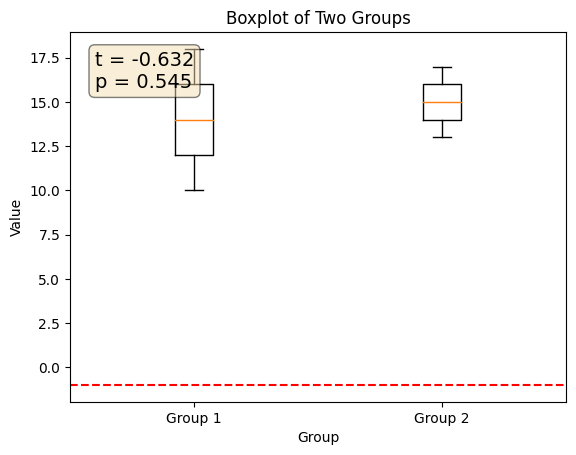

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
group1 = np.array([10, 12, 14, 16, 18])
group2 = np.array([13, 14, 15, 16, 17])

# Calculate t-test
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(group1, group2)

# Set up plot
fig, ax = plt.subplots()

# Create box plots of the two groups
bp = ax.boxplot([group1, group2], labels=['Group 1', 'Group 2'])

# Add a horizontal line for the mean difference
mean_diff = np.mean(group1) - np.mean(group2)
ax.axhline(mean_diff, color='red', linestyle='--')

# Add t-test result to the plot
textstr = 't = %.3f\np = %.3f' % (t_stat, p_val)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

# Set axis labels and title
ax.set_xlabel('Group')
ax.set_ylabel('Value')
ax.set_title('Boxplot of Two Groups')

# Show plot
plt.show()


In [78]:
%%markdown

The p-value in a t-test represents the probability of obtaining a test statistic as extreme as the one computed from your sample, assuming that the null hypothesis is true.

The p-value is calculated based on the t-statistic and the degrees of freedom of your sample. A small p-value (typically less than 0.05) indicates strong evidence against the null hypothesis, which suggests that the difference in means between your groups is statistically significant. On the other hand, a large p-value (greater than 0.05) suggests that the difference in means is not statistically significant, and that the results may have occurred by chance.

In general, a p-value of less than 0.05 is considered statistically significant, meaning that the results are not likely to have occurred by chance. However, it's important to keep in mind that a low p-value does not guarantee that the results are practical or meaningful, and that it's necessary to interpret the results in the context of the research question and the limitations of the study.


The p-value in a t-test represents the probability of obtaining a test statistic as extreme as the one computed from your sample, assuming that the null hypothesis is true.

The p-value is calculated based on the t-statistic and the degrees of freedom of your sample. A small p-value (typically less than 0.05) indicates strong evidence against the null hypothesis, which suggests that the difference in means between your groups is statistically significant. On the other hand, a large p-value (greater than 0.05) suggests that the difference in means is not statistically significant, and that the results may have occurred by chance.

In general, a p-value of less than 0.05 is considered statistically significant, meaning that the results are not likely to have occurred by chance. However, it's important to keep in mind that a low p-value does not guarantee that the results are practical or meaningful, and that it's necessary to interpret the results in the context of the research question and the limitations of the study.


In [79]:
df_openface_created_features_per_video.head()

,ID,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,...,eye0_angle_std,eye1_angle_std,head_pose_x_std,head_pose_y_std,head_pose_z_std,Gender,PHQ_Binary,PHQ_Score,PCL-C (PTSD),PTSD Severity
0,300,0.298513,0.132010,0.122615,0.062260,0.460049,0.051191,0.065715,0.929763,0.588317,...,0.023331,0.021851,0.013266,0.017009,0.008437,male,0,2,0,25.0
1,301,0.205044,0.154783,1.009734,0.053555,0.483790,0.857100,0.039581,1.086847,0.488762,...,0.025118,0.018666,0.010671,0.007554,0.005623,male,0,3,0,17.0
2,302,0.253516,0.145181,0.086798,0.076806,0.288110,0.963656,0.074013,1.234029,0.484229,...,0.024316,0.022133,0.010002,0.009583,0.009339,male,0,4,0,28.0
3,303,0.393109,0.189754,0.518012,0.081514,1.325568,0.093237,0.075992,1.889669,1.212773,...,0.031896,0.034936,0.009042,0.008466,0.005535,female,0,0,0,17.0
4,304,0.271433,0.118489,0.331437,0.159999,0.798692,0.207967,0.093851,0.726153,0.837516,...,0.037153,0.030210,0.011696,0.010415,0.006126,female,0,6,0,20.0


In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = df_openface_high_t_test.drop('ID', axis=1)

plt.figure(figsize=(15,8))
sns.boxplot(data=df)
plt.show()


NameError: name 'df_openface_high_t_test' is not defined

/var/folders/p4/x9h3xj457tb303r8d777sm7r0000gn/T/ipykernel_1217/3137143137.py:22: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.boxplot(by='Target', ax=ax)


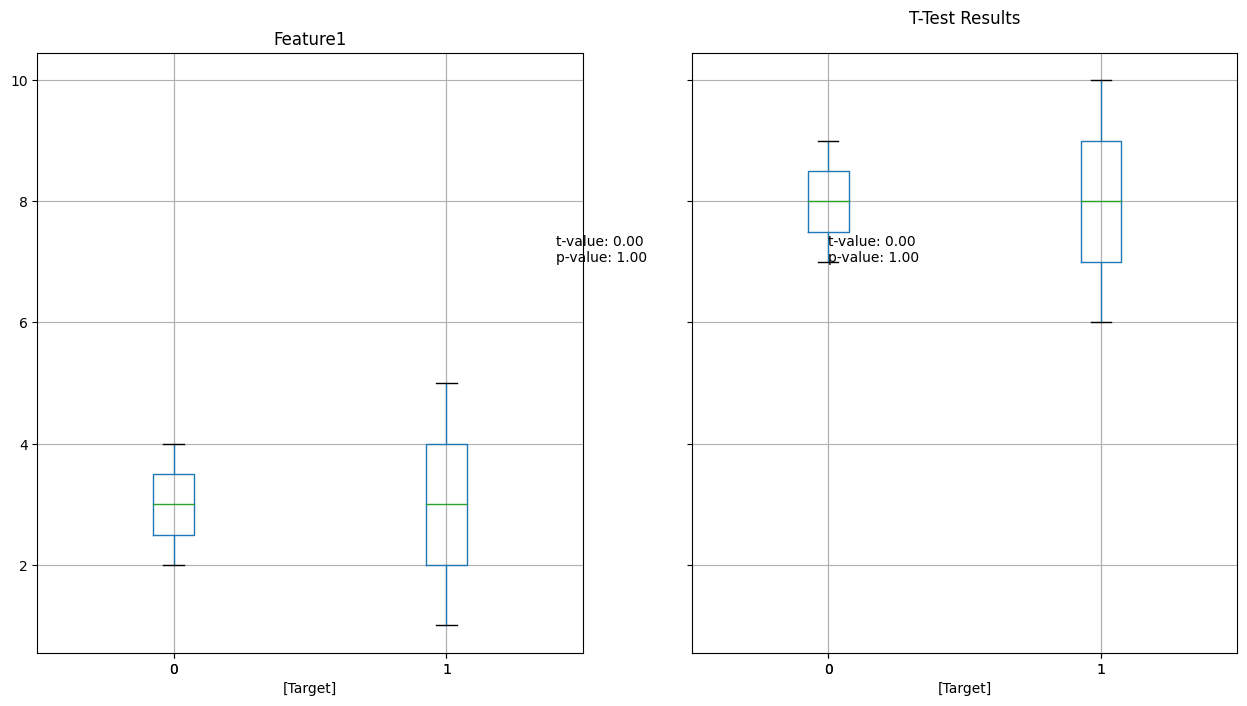

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Create a sample dataframe
df = pd.DataFrame({'Feature1': [1, 2, 3, 4, 5],
                   'Feature2': [6, 7, 8, 9, 10],
                   'Target': [1, 0, 1, 0, 1]})

# Split the dataframe into two based on the target variable
df1 = df[df['Target'] == 1][['Feature1', 'Feature2']]
df2 = df[df['Target'] == 0][['Feature1', 'Feature2']]

# Perform t-test for each feature
ttest_results = []
for col in df1.columns:
    t, p = stats.ttest_ind(df1[col], df2[col])
    ttest_results.append([col, t, p])

# Plot the box plot and add t-test results
fig, ax = plt.subplots(figsize=(15, 8))
df.boxplot(by='Target', ax=ax)
plt.suptitle("")
plt.title("T-Test Results\n")
for res in ttest_results:
    plt.text(df1.columns.get_loc(res[0]), 7, f"t-value: {res[1]:.2f}\np-value: {res[2]:.2f}")
plt.show()


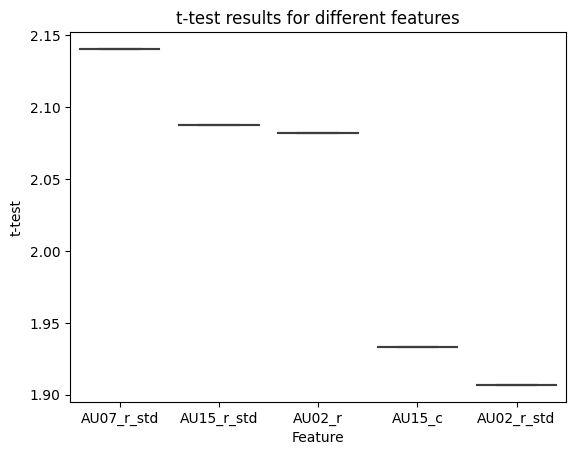

In [82]:
import seaborn as sns

# Create a box plot using the 't-test' column as the y-axis values
data = df_t_test_results_PHQ_Binary[:5]
sns.boxplot(x='Feature', y='t_stat', data=data)
# fig = plt.figure()
# ax = fig.add_subplot(111)
# data.boxplot(column='t-test', by='Feature', ax=ax)

# Add x-axis labels and a title
plt.xlabel('Feature')
plt.ylabel('t-test')
plt.title('t-test results for different features')

# ax2 = ax.twinx()
# ax2.scatter(data.index, data["p-value"], marker="o", s=20, color="r")
# ax2.set_ylabel("p-value")

# Show the plot
plt.show()

In [83]:
df_openface_created_features_per_video = df_openface_created_features_per_video.drop('PHQ_Binary', axis=1)
df_openface_created_features_per_video = df_openface_created_features_per_video.drop('PHQ_Score', axis=1)
df_openface_created_features_per_video = df_openface_created_features_per_video.drop('PCL-C (PTSD)', axis=1)
df_openface_created_features_per_video = df_openface_created_features_per_video.drop('PTSD Severity', axis=1)

In [84]:
df_openface_created_features_per_video.to_csv('df_openface_created_features_per_video.csv')

In [85]:
# df_openface_created_features_per_video = pd.read_csv('df_openface_created_features_per_video.csv', index_col = [0])
df_openface_created_features_per_video

,ID,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,...,AU23_r_std,AU25_r_std,AU26_r_std,AU45_r_std,eye0_angle_std,eye1_angle_std,head_pose_x_std,head_pose_y_std,head_pose_z_std,Gender
0,300,0.298513,0.132010,0.122615,0.062260,0.460049,0.051191,0.065715,0.929763,0.588317,...,0.340996,0.666174,0.662694,0.646234,0.023331,0.021851,0.013266,0.017009,0.008437,male
1,301,0.205044,0.154783,1.009734,0.053555,0.483790,0.857100,0.039581,1.086847,0.488762,...,0.339395,0.458752,0.250679,0.347451,0.025118,0.018666,0.010671,0.007554,0.005623,male
2,302,0.253516,0.145181,0.086798,0.076806,0.288110,0.963656,0.074013,1.234029,0.484229,...,0.716242,0.830808,0.613464,0.398263,0.024316,0.022133,0.010002,0.009583,0.009339,male
3,303,0.393109,0.189754,0.518012,0.081514,1.325568,0.093237,0.075992,1.889669,1.212773,...,0.546391,0.955757,0.765435,0.544440,0.031896,0.034936,0.009042,0.008466,0.005535,female
4,304,0.271433,0.118489,0.331437,0.159999,0.798692,0.207967,0.093851,0.726153,0.837516,...,0.388773,0.748877,0.565770,0.634920,0.037153,0.030210,0.011696,0.010415,0.006126,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,713,0.291357,0.118184,0.669194,0.052119,1.506491,1.824435,0.113900,2.029745,0.616222,...,0.442006,0.556096,0.591219,0.429948,0.017687,0.017122,0.010664,0.008420,0.004629,male
271,715,0.506630,0.353144,1.265457,0.091625,0.505030,0.772965,0.149526,1.758954,0.325458,...,0.489750,0.950080,0.529494,0.477632,0.024951,0.021491,0.016165,0.007437,0.008558,male
272,716,0.146594,0.068596,0.655528,0.098758,0.782924,0.588501,0.070597,1.097390,0.379867,...,0.498464,0.652784,0.494035,0.743438,0.020147,0.016603,0.011515,0.005378,0.004217,male
273,717,0.341520,0.148997,0.226543,0.091597,0.565864,0.052517,0.134311,1.384084,0.328668,...,0.525313,0.643432,0.589447,0.531911,0.026507,0.027527,0.013710,0.008462,0.005552,male


In [86]:
train_IDs = df_train_split['Participant_ID']
dev_IDs = df_dev_split['Participant_ID']
test_IDs = df_test_split['Participant_ID']

train_IDs = [str(x) for x in train_IDs]
dev_IDs = [str(x) for x in dev_IDs]
test_IDs = [str(x) for x in test_IDs]

df_openface_created_features_per_video['ID'] = df_openface_created_features_per_video['ID'].astype(str)

In [87]:
df_openface_created_features_per_video = df_openface_created_features_per_video.drop('Gender', axis=1)
df_openface_created_features_per_video.head()

,ID,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,...,AU20_r_std,AU23_r_std,AU25_r_std,AU26_r_std,AU45_r_std,eye0_angle_std,eye1_angle_std,head_pose_x_std,head_pose_y_std,head_pose_z_std
0,300,0.298513,0.132010,0.122615,0.062260,0.460049,0.051191,0.065715,0.929763,0.588317,...,0.243962,0.340996,0.666174,0.662694,0.646234,0.023331,0.021851,0.013266,0.017009,0.008437
1,301,0.205044,0.154783,1.009734,0.053555,0.483790,0.857100,0.039581,1.086847,0.488762,...,0.155363,0.339395,0.458752,0.250679,0.347451,0.025118,0.018666,0.010671,0.007554,0.005623
2,302,0.253516,0.145181,0.086798,0.076806,0.288110,0.963656,0.074013,1.234029,0.484229,...,0.374230,0.716242,0.830808,0.613464,0.398263,0.024316,0.022133,0.010002,0.009583,0.009339
3,303,0.393109,0.189754,0.518012,0.081514,1.325568,0.093237,0.075992,1.889669,1.212773,...,0.237093,0.546391,0.955757,0.765435,0.544440,0.031896,0.034936,0.009042,0.008466,0.005535
4,304,0.271433,0.118489,0.331437,0.159999,0.798692,0.207967,0.093851,0.726153,0.837516,...,0.332169,0.388773,0.748877,0.565770,0.634920,0.037153,0.030210,0.011696,0.010415,0.006126


In [105]:
AU_intensities = df_openface_created_features_per_video.filter(like='_r').columns.to_list() 
AU_presence = df_openface_created_features_per_video.filter(like='_c').columns.to_list() 
eye_gaze = df_openface_created_features_per_video.filter(like='eye').columns.to_list()
head_pose = df_openface_created_features_per_video.filter(like='head').columns.to_list()

df_AU_intensities = df_openface_created_features_per_video.drop(AU_presence+eye_gaze+head_pose, axis=1)
df_AU_presence = df_openface_created_features_per_video.drop(AU_intensities+eye_gaze+head_pose, axis=1)
df_eye_gaze = df_openface_created_features_per_video.drop(AU_intensities+AU_presence+head_pose, axis=1)
df_head_pose = df_openface_created_features_per_video.drop(AU_intensities+eye_gaze+AU_presence, axis=1)
df_AU_intens_eye_head = df_openface_created_features_per_video.drop(AU_presence, axis=1)
df_AU_presence_eye_head = df_openface_created_features_per_video.drop(AU_intensities, axis=1)
df_eye_head = df_openface_created_features_per_video.drop(AU_intensities+AU_presence, axis=1)
df_all_features = df_openface_created_features_per_video

In [107]:
df_AU_intensities
tmp = df_AU_intensities.filter(like='_std').columns.to_list()
tmp = df_AU_intensities.filter(like='_std').columns.to_list()

,ID,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,...,AU10_r_std,AU12_r_std,AU14_r_std,AU15_r_std,AU17_r_std,AU20_r_std,AU23_r_std,AU25_r_std,AU26_r_std,AU45_r_std
0,300,0.298513,0.132010,0.122615,0.062260,0.460049,0.051191,0.065715,0.929763,0.588317,...,0.424522,0.467748,0.544067,0.592535,0.393383,0.243962,0.340996,0.666174,0.662694,0.646234
1,301,0.205044,0.154783,1.009734,0.053555,0.483790,0.857100,0.039581,1.086847,0.488762,...,0.315671,0.227434,0.339821,0.303245,0.307220,0.155363,0.339395,0.458752,0.250679,0.347451
2,302,0.253516,0.145181,0.086798,0.076806,0.288110,0.963656,0.074013,1.234029,0.484229,...,0.553623,0.311742,0.648068,1.006035,0.688945,0.374230,0.716242,0.830808,0.613464,0.398263
3,303,0.393109,0.189754,0.518012,0.081514,1.325568,0.093237,0.075992,1.889669,1.212773,...,0.641858,0.621353,0.829438,0.667666,0.828022,0.237093,0.546391,0.955757,0.765435,0.544440
4,304,0.271433,0.118489,0.331437,0.159999,0.798692,0.207967,0.093851,0.726153,0.837516,...,0.511861,0.627512,0.756320,0.843683,0.733445,0.332169,0.388773,0.748877,0.565770,0.634920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,713,0.291357,0.118184,0.669194,0.052119,1.506491,1.824435,0.113900,2.029745,0.616222,...,0.688569,0.440422,0.974618,0.654349,0.580122,0.397892,0.442006,0.556096,0.591219,0.429948
271,715,0.506630,0.353144,1.265457,0.091625,0.505030,0.772965,0.149526,1.758954,0.325458,...,0.823126,0.358631,0.669698,0.346542,0.705427,0.275629,0.489750,0.950080,0.529494,0.477632
272,716,0.146594,0.068596,0.655528,0.098758,0.782924,0.588501,0.070597,1.097390,0.379867,...,0.298420,0.266804,0.443258,0.303040,0.441773,0.205950,0.498464,0.652784,0.494035,0.743438
273,717,0.341520,0.148997,0.226543,0.091597,0.565864,0.052517,0.134311,1.384084,0.328668,...,0.575782,0.324108,0.651999,0.349010,0.695638,0.490258,0.525313,0.643432,0.589447,0.531911


In [89]:
#get the highest t-test features 
temp = ['ID'] + high_t_test_features
df_openface_high_t_test = df_openface_created_features_per_video[temp]
df_openface_high_t_test.head()

,ID,AU07_r_std,AU15_r_std,AU02_r,AU15_c,AU02_r_std
0,300,0.188309,0.592535,0.132010,0.084516,0.337634
1,301,0.361515,0.303245,0.154783,0.021723,0.439737
2,302,0.593037,1.006035,0.145181,0.389953,0.348193
3,303,0.235524,0.667666,0.189754,0.349094,0.421261
4,304,0.405599,0.843683,0.118489,0.309080,0.274576


In [90]:
df_source = df_openface_high_t_test

In [91]:
df_train = df_source[df_source['ID'].isin(train_IDs)]
df_dev = df_source[df_source['ID'].isin(dev_IDs)]
df_test = df_source[df_source['ID'].isin(test_IDs)]

In [92]:
df_train_labels = pd.read_csv(label_dir+'train_split.csv', delimiter=',', encoding='utf-8')
df_dev_labels = pd.read_csv(label_dir+'dev_split.csv', delimiter=',', encoding='utf-8')
df_test_labels = pd.read_csv(label_dir+'test_split.csv', delimiter=',', encoding='utf-8')
df_train_labels

,Participant_ID,Gender,PHQ_Binary,PHQ_Score,PCL-C (PTSD),PTSD Severity
0,302,male,0,4,0,28
1,303,female,0,0,0,17
2,304,female,0,6,0,20
3,305,male,0,7,0,28
4,307,female,0,4,0,23
...,...,...,...,...,...,...
158,695,male,0,7,1,62
159,697,male,0,5,0,24
160,702,male,0,0,0,19
161,703,male,0,8,0,28


In [93]:
max(df_train_labels['PHQ_Score'])

23

In [94]:
min(df_train_labels['PHQ_Score'])

0

In [95]:
df_train = df_train.reset_index(drop=True)
df_dev = df_dev.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_train

,ID,AU07_r_std,AU15_r_std,AU02_r,AU15_c,AU02_r_std
0,302,0.593037,1.006035,0.145181,0.389953,0.348193
1,303,0.235524,0.667666,0.189754,0.349094,0.421261
2,304,0.405599,0.843683,0.118489,0.309080,0.274576
3,305,0.359890,0.264849,0.150104,0.171460,0.339094
4,307,0.276060,0.569899,0.249694,0.377388,0.582973
...,...,...,...,...,...,...
158,695,0.734496,0.525336,0.146973,0.325952,0.323689
159,697,0.707462,0.281599,0.228241,0.141252,0.509745
160,702,0.421301,1.129631,0.061807,0.285120,0.200006
161,703,0.470520,0.482494,0.230622,0.159454,0.591363


In [96]:
def makeDataset(df_labels, df_X):
    df_labels = df_labels.drop('Gender', axis=1)
    df_labels = df_labels.drop('PTSD Severity', axis=1)
#     df_labels = df_labels.drop('PHQ_Score', axis=1)
    df_labels = df_labels.drop('PCL-C (PTSD)', axis=1)
    df_labels = df_labels.drop('PHQ_Binary', axis=1)
    df_labels = df_labels.dropna()
    file  = np.array(df_labels)
    print(df_labels)
    X_temp = []
    Y_temp = []
    for i in range(len(file)):
        patientID = (str(int(file[i][0])))
        features_per_ID = df_X.loc[df_X['ID'] == patientID]
        features_per_ID = features_per_ID.drop('ID', axis=1)
#         features_per_ID = features_per_ID.drop('Gender', axis=1)
        X = np.array(features_per_ID)

        X_temp.append(X)
        Y_temp.append(int(file[i][1]))

    Y_temp = np.asarray(Y_temp)
    return X_temp, Y_temp

In [97]:
X_train, Y_train = makeDataset(df_train_labels,df_train)
X_dev, Y_dev = makeDataset(df_dev_labels,df_dev)
X_test, Y_test = makeDataset(df_test_labels,df_test)

     Participant_ID  PHQ_Score
0               302          4
1               303          0
2               304          6
3               305          7
4               307          4
..              ...        ...
158             695          7
159             697          5
160             702          0
161             703          8
162             707          1

[163 rows x 2 columns]
    Participant_ID  PHQ_Score
0              300          2
1              301          3
2              306          0
3              317          8
4              320         11
5              321         20
6              331          8
7              334          5
8              336          7
9              343          9
10             344         11
11             347         16
12             350         11
13             365         12
14             371          9
15             373          9
16             374          2
17             381         16
18             382          0
19  

In [98]:
X_train = np.concatenate((X_train, X_dev), 0)
Y_train = np.concatenate((Y_train, Y_dev), 0)

print(len(X_train))
print(Y_train.shape)

219
(219,)


In [99]:
np.count_nonzero(Y_train)

186

In [100]:
Y_train.shape[0]-np.count_nonzero(Y_train)

33

In [101]:
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))
print(X_train.shape)
print(Y_train.shape)

X_test = np.array(X_test)
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))
print(X_test.shape)

(219, 5)
(219,)
(56, 5)


In [102]:
# Regression model based on PHQ_Score
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train, Y_train)
y_pred = svr_model.predict(X_test)
mae = mean_absolute_error(Y_test, y_pred)
rmse = mean_squared_error(Y_test, y_pred)**0.5
# score = svr_model.score(X_test, Y_test)
# print('score: ', score)
print('mae: ', mae)
print('rmse: ', rmse)

mae:  5.700544351649577
rmse:  7.053410926326115


In [103]:
X_train = np.concatenate((X_train, X), axis=1)
X_train.shape

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 219 and the array at index 1 has size 275

In [104]:
# regression model based on PHQ_Score

# svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
# svr_model.fit(X_train, Y_train)
# y_pred = svr_model.predict(X_test)
# mae = mean_absolute_error(Y_test, y_pred)
# rmse = mean_squared_error(Y_test, y_pred)**0.5
# # score = svr_model.score(X_test, Y_test)
# # print('score: ', score)

mae_list = []
rmse_list = []

svr_model = SVR(kernel='linear', C=2, gamma=1)
# SVR(kernel='rbf', C=2, gamma=0.1)
# Create a KFold instance with 10 splits
kf = KFold(n_splits=10)

# Loop through the splits (each split is a tuple of train and test indices)
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    x_train, x_test = X_train[train_index], X_train[test_index]
    y_train, y_test = Y_train[train_index], Y_train[test_index]
    
    print(f'Fold {i+1}:')
#     print(f'X_train shape: {x_train.shape}')
#     print(f'y_train shape: {y_train.shape}')
#     print(f'X_test shape: {x_test.shape}')
#     print(f'y_test shape: {y_test.shape}')
        
    # Train your model on the train data and test it on the test data
    svr_model.fit(x_train, y_train)
    y_pred = svr_model.predict(x_test)
    mae = mean_absolute_error(y_test, y_pred)
    mae_list.append(mae)
    print('mae: ', mae)
    rmse = mean_squared_error(y_test, y_pred)**0.5
    print('rmse: ', rmse)
    rmse_list.append(rmse)

mean_mae = sum(mae_list) / len(mae_list)
mean_rmse = sum(rmse_list) / len(rmse_list)
print('mean mae: ', mean_mae)
print('mean rmse: ', mean_rmse)

Fold 1:
mae:  4.119988569665243
rmse:  5.9950309910322
Fold 2:
mae:  6.800885844773455
rmse:  8.213560867536254
Fold 3:
mae:  5.999666731236848
rmse:  7.080869597279276
Fold 4:
mae:  4.238567298202519
rmse:  5.19178555348748
Fold 5:
mae:  4.445429080850744
rmse:  5.586662575449838
Fold 6:
mae:  4.575123847010289
rmse:  5.4731177752084985
Fold 7:
mae:  4.564563255437521
rmse:  5.131103337114722
Fold 8:
mae:  5.755079842941291
rmse:  6.974127276110786
Fold 9:
mae:  5.821642969697004
rmse:  7.136620915295562
Fold 10:
mae:  3.8883011216521326
rmse:  4.7512957544134125
mean mae:  5.020924856146705
mean rmse:  6.153417464292803


In [ ]:
svr_model.fit(X_train, Y_train)
y_pred = svr_model.predict(X_test)
mae = mean_absolute_error(Y_test, y_pred)
print('mae: ', mae)
rmse = mean_squared_error(Y_test, y_pred)**0.5
print('rmse: ', rmse)

In [ ]:
score = svr_model.score(X_test, Y_test)
print('score: ', score)

In [ ]:
print("SVR: "+ str(svr_model.score(X_test,Y_test)))

In [ ]:
mae

In [ ]:
clf1 = RandomForestClassifier()
clf1.fit(X_train,Y_train)
clf1.predict(X_test)
print("Random forest: "+ str(clf1.score(X_test,Y_test)))

classifier2 = SVC(kernel = 'poly', random_state = 0)
classifier2.fit(X_train, Y_train)
classifier2.predict(X_test)
print("SVM rbf: "+ str(classifier2.score(X_test,Y_test)))

clf1.predict(X_train)
print("Random forest: train"+ str(clf1.score(X_train,Y_train)))

classifier2.predict(X_train)
print("SVM: train  "+ str(classifier2.score(X_train,Y_train)))

y_pred = clf1.predict(X_test)
print(classification_report(Y_test, y_pred))

In [ ]:
y_pred = clf1.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
print(f'Mean squared error: {mse:.2f}')

y_pred = clf1.predict(X_test)
print(classification_report(Y_test, y_pred))

y_pred = classifier2.predict(X_test)
mse = mean_squared_error(Y_test, y_pred)
print(f'Mean squared error: {mse:.2f}')

In [ ]:
y_pred = clf1.predict(X_test)

mae = mean_absolute_error(Y_test, y_pred)
rmse = mean_squared_error(Y_test, y_pred)**0.5
print('MAE: ', mae)
print('RMSE: ', rmse)

In [ ]:
print('Y_test: ', Y_test[:40])
print('y_pred: ', y_pred[:40])

In [ ]:
import xgboost
import shap

# train an XGBoost model
# X, y = shap.datasets.boston()
# model = xgboost.XGBRegressor().fit(X, y)

model = RandomForestClassifier()
model.fit(X_train,Y_train)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.beeswarm(shap_values)

In [ ]:
df_train = df_train.drop(['ID'], axis=1)
# df_train = df_train.drop(['Gender'], axis=1)
df_train

In [ ]:
X_train = pd.DataFrame(data=X_train,columns=df_train.columns)
Y_train

In [ ]:
import matplotlib
print(matplotlib.__version__)

In [ ]:
# fit model no training 
from xgboost import XGBClassifier
import shap
import matplotlib
import matplotlib.pyplot as plt

model = XGBClassifier()
X_train = pd.DataFrame(data=X_train,columns=df_train.columns)

model.fit(X_train, Y_train)

# feature importance
print(model.feature_importances_)

# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()


In [ ]:
#import XGBoost classifier and accuracy
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

#instantiate model and train
model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
model_fitted = model.fit(X_train, Y_train)

# make predictions for test set
# X_test = pd.DataFrame(data=X_test,columns=X_normalized.columns)
# X_train = pd.DataFrame(data=X_train,columns=X_normalized.columns)
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(Y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
explainer = shap.Explainer(model_fitted)
shap_values = explainer.shap_values(X_test)

# shap.summary_plot(shap_values, X_test)
# shap.summary_plot(shap_values, X_test, plot_type="bar")

# explainer = shap.KernelExplainer(model, X_test[:100,:])
# shap_values = explainer.shap_values(X_test[:100,:])
shap.summary_plot(shap_values, features=X_test, feature_names=df_train.columns, show=False)


In [ ]:
shap.initjs()
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[0])

In [ ]:
# create the model
model = LinearRegression()

# fit the model to the training data
model.fit(X_train, Y_train)

# make predictions on the test data
predictions = model.predict(X_test)

# compute the mean squared error of the predictions
mse = np.mean((predictions - Y_test) ** 2)
print(f'Mean squared error: {mse:.2f}')
mse

class RfVideo:
  def __init__(self):
    self.classifier = RandomForestClassifier()
  
  def fitModel(self, X, Y):
    self.classifier.fit(X, Y)
  
  def predictModel(self, X):
    return self.classifier.predict(X)
  
  def scoreModel(self, X, Y):
    return self.classifier.score(X, Y)

class SVMVideo:
  def __init__(self, kernel = "rbf"):
    self.classifier = SVC(kernel = kernel, random_state = 0)
  
  def fitModel(self, X, Y):
    self.classifier.fit(X, Y)
  
  def predictModel(self, X):
    return self.classifier.predict(X)
  
  def scoreModel(self, X, Y):
    return self.classifier.score(X, Y)

print("Random forest: ")
rfModel = RfVideo()
rfModel.fitModel(X_train, Y_train)
Y_pred1  = rfModel.predictModel(X_test)
print(classification_report(Y_test, Y_pred1))

print("SVM: ")
svmModel = SVMVideo()
svmModel.fitModel(X_train, Y_train)
Y_pred2  = svmModel.predictModel(X_test)
print(classification_report(Y_test, Y_pred2))

In [ ]:
AU23_depression = df_openface_all_AUs[df_openface_all_AUs['PHQ_Binary'] == 1]['AU23_c'].mean()
AU23_no_depression = df_openface_all_AUs[df_openface_all_AUs['PHQ_Binary'] == 0]['AU23_c'].mean()
odds_ratio = AU23_depression / AU23_no_depression
print('odds_ratio: ', odds_ratio)

# AU23 is the Lip Tightener

# If the odds ratio is greater than 1, it means that the facial action unit 
# 'AU25' is more likely to occur in individuals with depression, and if the 
# odds ratio is less than 1, it means that the 
# facial action unit 'AU25' is more likely to occur in individuals without depression.

In [ ]:
condition = df_openface_all_AUs['PHQ_Binary'] == 1
# print(df_openface_all_AUs[condition]['PHQ_Binary'])
print(df_openface_all_AUs[condition]['AU23_c'])

In [ ]:
# Group the data by video
grouped = df_openface_all_AUs.groupby("ID")

# Get the mode of each facial action unit across all frames
mode_action_units = grouped['AU45_r', 'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c', 'AU07_c', 'AU09_c', \
                            'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c', 'AU20_c', 'AU23_c', 'AU25_c', \
                            'AU26_c', 'AU28_c', 'AU45_c'].agg(lambda x: x.value_counts().index[0])


In [ ]:
df = df_openface_all_AUs.groupby("ID").apply(lambda x: x) 
df = df[['ID', 'PHQ_Binary']]

df_AUc_PHQ = pd.merge(mode_action_units, df, on='ID') 
df_AUc_PHQ

In [ ]:
df_temp.dtypes

In [ ]:
# calculate Pearson's correlation coefficient for each facial action unit/emotion
correlations = {}
labels_temp = ['ID', 'PHQ_Binary', 'PHQ_Score', 'PCL-C (PTSD)', 'PTSD Severity', 'Gender', 'Gender_x', 'Gender_y']
df_temp = pd.merge(df_openface_created_features_per_video, df_labels, on='ID')

for col in df_openface_created_features_per_video.columns:
    if col not in labels_temp:
        df_temp[col] = df_temp[col].astype(float)
        correlations[col] = df_temp[col].corr(df_temp['PHQ_Binary'])

# sort correlations in descending order
sorted_correlations = {k: v for k, v in sorted(correlations.items(), key=lambda item: item[1], reverse=True)}

# print the top 10 most strongly correlated facial action units/emotions
print('Top 10 most strongly correlated features:')
for feature, correlation in list(sorted_correlations.items())[:10]:
    print(f'{feature}: {correlation}')
    


In [ ]:
import matplotlib.pyplot as plt

# extract the top 10 most strongly correlated features
top_10_features = list(sorted_correlations.items())[:10]

print(top_10_features)

AU_r_list = ['AU07_r', 'AU04_r', 'AU06_r', 'AU23_r']
top_10_features = [(x,y) for x,y in top_10_features if  x not in AU_r_list]

print(top_10_features)

# extract the feature names and correlation coefficients
feature_names = [feature for feature, correlation in top_10_features]
correlation_coefficients = [correlation for feature, correlation in top_10_features]

# create a bar chart
fig, ax = plt.subplots()
ax.bar(feature_names, correlation_coefficients)
ax.set_xlabel('Facial Action Unit/Emotion')
ax.set_ylabel('Correlation Coefficient')
ax.set_title('Top 10 most strongly correlated features')
ax.set_xticklabels(feature_names, rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
# import necessary libraries
import matplotlib.pyplot as plt

# create a bar plot of the coefficients
plt.bar(X.columns, model.coef_)
plt.xlabel('Feature')
plt.ylabel('Coefficient')
plt.title('Linear Regression Coefficients')
plt.show()


In [ ]:
# # Define threshold distance for gaze movement
# threshold_distance = 0.5 # degrees of visual angle

# for name, group in grouped:
#     group = group.reset_index(drop=True)
    
#     # Initialize a counter to keep track of the duration of each gaze fixation
#     fixation_duration = 0

#     # Initialize a list to store the duration of all gaze fixations
#     fixation_durations = []

#     # Set the initial gaze position
#     previous_gaze_x = group.iloc[0]['gaze_angle_x']
#     previous_gaze_y = group.iloc[0]['gaze_angle_y']

#     # Iterate through each frame of the video
#     for index, row in group.iterrows():
#         current_gaze_x = row['gaze_angle_x']
#         current_gaze_y = row['gaze_angle_y']
    
#         # Calculate the distance between the current gaze position and the previous gaze position
#         distance = ((current_gaze_x - previous_gaze_x) ** 2 + (current_gaze_y - previous_gaze_y) ** 2) ** 0.5

#         if distance < threshold_distance:
#             # Gaze is still fixated, increment the counter
#             fixation_duration += 1       
#         if (distance >= threshold_distance) or (index == group.shape[0]-1):
#             # Gaze has moved, consider this the end of a fixation
#             fixation_durations.append(fixation_duration)
#             fixation_duration = 0

#             # Update the previous gaze position
#             previous_gaze_x = current_gaze_x
#             previous_gaze_y = current_gaze_y

#     total_fixation_duration = sum(fixation_durations)
#     max_fixation_duration = max(fixation_durations)
    
#     print('----------------------------')
#     print('name: ', name)
#     print('fixation_durations: ', fixation_durations)
#     print('max_fixation_duration: ', max_fixation_duration)
    
    
#     # Divide the total duration of gaze fixations by the total number of frames to get the proportion of video duration where gaze was fixated on a particular point or region
#     proportion_of_video_duration = total_fixation_duration / group.shape[0]

In [ ]:
# df1 = df_openface_all_AUs.loc[:, :'ID']
# df2 = df_openface_all_AUs.loc[:, 'AU01_r':]
# df_openface_all_AUs = pd.concat([df1, df2], axis=1, join='outer')
# df_openface_all_AUs

In [ ]:
# df_openface_all_AUs['Gender'] = 0
# df_openface_all_AUs['PHQ_Binary'] = 0
# df_openface_all_AUs['PHQ_Score'] = 0
# df_openface_all_AUs['PCL-C (PTSD)'] = 0
# df_openface_all_AUs['PTSD Severity'] = 0

# IDs = df_labels['Participant_ID'].tolist()

# for ID in IDs:
#     print('ID: ', ID)    
#     label_ind = df_labels.loc[df_labels['Participant_ID'] == ID].index[0]   
#     Gender = df_labels.at[label_ind, 'Gender']
#     PHQ_Binary = df_labels.at[label_ind, 'PHQ_Binary']
#     PHQ_Score = df_labels.at[label_ind, 'PHQ_Score']
#     PCL_C = df_labels.at[label_ind, 'PCL-C (PTSD)']
#     PTSD = df_labels.at[label_ind,'PTSD Severity']
    
#     indices = df_openface_all_AUs.loc[df_openface_all_AUs['ID'] == str(ID)].index
#     indices = indices.tolist()
#     for i in indices:
#         df_openface_all_AUs.iloc[i, df_openface_all_AUs.columns.get_loc('Gender')] = Gender
#         df_openface_all_AUs.iloc[i, df_openface_all_AUs.columns.get_loc('PHQ_Binary')] = PHQ_Binary
#         df_openface_all_AUs.iloc[i, df_openface_all_AUs.columns.get_loc('PHQ_Score')] = PHQ_Score
#         df_openface_all_AUs.iloc[i, df_openface_all_AUs.columns.get_loc('PCL-C (PTSD)')] = PCL_C
#         df_openface_all_AUs.iloc[i, df_openface_all_AUs.columns.get_loc('PTSD Severity')] = PTSD


In [ ]:
train = np.array(pd.read_csv(label_dir+'train_split.csv',delimiter=',',encoding='utf-8'))
dev = np.array(pd.read_csv(label_dir+'dev_split.csv',delimiter=',',encoding='utf-8'))
test = np.array(pd.read_csv(label_dir+'test_split.csv',delimiter=',',encoding='utf-8'))

In [ ]:
train_data_labels = train
dev_data_labels = dev
test_data_labels = test

all_data_labels = np.concatenate((train_data_labels, np.concatenate((dev_data_labels, test_data_labels))))

dataset1 = dev
dataset2 = test
dataset3 = train
dataset = np.concatenate((dataset1, np.concatenate((dataset2, dataset3))))

In [ ]:
#Text processing 

countPos = 0
def checkPosNeg(dataset, index):
    for i in range(0, len(dataset)):
        if(dataset[i][0] == index):
            return dataset[i][2]
    return 0

text_data = []
Y = []

Data_test = []
Y_test = []
index = -1
for i in range(0, len(dataset3)):
    val = checkPosNeg(dataset, dataset3[i][0])
    if(val == 0 and countPos>38):
        continue
    Y.append(val)
    index+=1
    if(Y[index] == 0):
        countPos+=1
    
    fileName = splitted_dataset_dir + 'train_data' + \
                str(int(dataset3[i][0])) + '_P/' + str(int(dataset3[i][0])) + "_Transcript.csv"
    Data.append(np.array(pd.read_csv(fileName,delimiter=',',encoding='utf-8'))[:, 2:3])
    
for i in range(0, len(dev_data_labels)):
    val = checkPosNeg(dataset, dataset1[i][0])
    if(val == 0):
        continue
    Y.append(val)
    fileName = splitted_dataset_dir + 'dev_data' + \
                str(int(dev_data_labels[i][0])) + '_P/' + str(int(dev_data_labels[i][0])) + "_Transcript.csv"
    text_data.append(np.array(pd.read_csv(fileName,delimiter=',',encoding='utf-8'))[:, 2:3])
    
for i in range(0, len(dataset2)):
    Y_test.append(checkPosNeg(dataset, dataset2[i][0]))
    fileName = "/Users/misha/Desktop/My_Work/Datasets/DAIC_WOZ/splitted_dataset/test_data/" + \
                str(int(dataset2[i][0])) + '_P/' + str(int(dataset2[i][0])) + "_Transcript.csv"
    Data_test.append(np.array(pd.read_csv(fileName,delimiter=',',encoding='utf-8'))[:, 2:3])
